**Business Question: How does asset utilization vary across facilities, and what factors contribute to higher or lower efficiency?**

In [ ]:
os.getcwd()

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# loading in the datasets 

status_df = pd.read_csv('/Users/brashonford/StatusCodes.csv')
schedule_df = pd.read_csv('/Users/brashonford/Schedule.csv')
cycles_df = pd.read_csv('/Users/brashonford/Cycles.csv')

In [28]:
# Updating the dates to dateformat 
status_df["Date"] = pd.to_datetime(status_df["Date"])
cycles_df["Date"] = pd.to_datetime(cycles_df["Date"])

# Schedule has a 'Start' and "End" Date

In [29]:
status_df.head()

,Facility,SerialNo,ModelNo,Status Code,Date
0,Messier 37,1,1.0,A10,2012-11-02
1,Messier 37,1,1.0,A10,2013-01-24
2,Messier 37,1,1.0,G31,2013-02-25
3,Messier 37,1,1.0,A10,2013-03-06
4,Messier 37,1,1.0,A10,2013-04-03


In [30]:
schedule_df.head()

,Facility,ACTIVITY,START,END
0,HYADES,ACTIVITY U2,2004-01-01,NaN
1,PLANT 9,ACTIVITY U1,2004-01-01,NaN
2,ARP-MADORE 2,ACTIVITY U3,2004-01-01,NaN
3,1996 PW,ACTIVITY Q3,2004-01-01,NaN
4,M1,ACTIVITY B,2012-10-30,2013-02-03


In [31]:
cycles_df.head()

,SerialNo,Cycles,Hours,Date
0,1,1.0,1.7,2013-01-07
1,1,1.0,1.4,2013-01-07
2,1,1.0,1.4,2013-01-07
3,1,1.0,1.3,2013-01-08
4,1,1.0,1.4,2013-01-08


In [32]:
# Convert START and END to datetime
schedule_df["START"] = pd.to_datetime(schedule_df["START"])
schedule_df["END"] = pd.to_datetime(schedule_df["END"])

# Fill missing END dates with a large future date
schedule_df["END"].fillna(pd.to_datetime("2099-12-31"), inplace=True)

/var/folders/8y/7y64ckgn0rq30w9ylrrcq_hc0000gn/T/ipykernel_66195/3584563529.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  schedule_df["END"].fillna(pd.to_datetime("2099-12-31"), inplace=True)


In [14]:
schedule_df.columns

Index(['Facility', 'ACTIVITY', 'START', 'END'], dtype='object')

In [13]:
schedule_df.rename(columns={"FACILITY": "Facility"}, inplace=True)

In [70]:
cycles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37514 entries, 0 to 37513
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   SerialNo  37514 non-null  int64         
 1   Cycles    37513 non-null  float64       
 2   Hours     37513 non-null  float64       
 3   Date      37514 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.1 MB


In [71]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146 entries, 0 to 1145
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Facility     1146 non-null   object        
 1   SerialNo     1146 non-null   int64         
 2   ModelNo      1142 non-null   float64       
 3   Status Code  1146 non-null   object        
 4   Date         1146 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 44.9+ KB


In [72]:
schedule_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Facility  594 non-null    object        
 1   ACTIVITY  594 non-null    object        
 2   START     594 non-null    datetime64[ns]
 3   END       594 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 18.7+ KB


In [33]:
merged_df = (
    status_df
    .merge(cycles_df, on=["SerialNo", "Date"], how="left")
)

In [15]:
merged_df.columns

Index(['Facility', 'SerialNo', 'ModelNo', 'Status Code', 'Date', 'Cycles',
       'Hours'],
      dtype='object')

In [34]:
# Now merge
merged_df2 = merged_df.merge(schedule_df, on="Facility", how="left")


In [35]:
merged_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5677 entries, 0 to 5676
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Facility     5677 non-null   object        
 1   SerialNo     5677 non-null   int64         
 2   ModelNo      5672 non-null   float64       
 3   Status Code  5677 non-null   object        
 4   Date         5677 non-null   datetime64[ns]
 5   Cycles       1443 non-null   float64       
 6   Hours        1443 non-null   float64       
 7   ACTIVITY     4947 non-null   object        
 8   START        4947 non-null   datetime64[ns]
 9   END          4947 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(3), int64(1), object(3)
memory usage: 443.6+ KB


In [ ]:
merged_df.head()

In [ ]:
merged_df.columns = merged_df.columns.str.strip().str.upper()

In [19]:
merged_df2.columns

Index(['Facility', 'SerialNo', 'ModelNo', 'Status Code', 'Date', 'Cycles',
       'Hours', 'ACTIVITY', 'START', 'END'],
      dtype='object')

In [ ]:
print("merged_df columns:", merged_df.columns)
print("schedule_df columns:", schedule_df.columns)


In [36]:
merged_df2.head()

,Facility,SerialNo,ModelNo,Status Code,Date,Cycles,Hours,ACTIVITY,START,END
0,Messier 37,1,1.0,A10,2012-11-02,NaN,NaN,NaN,NaT,NaT
1,Messier 37,1,1.0,A10,2013-01-24,1.0,1.5,NaN,NaT,NaT
2,Messier 37,1,1.0,A10,2013-01-24,1.0,1.1,NaN,NaT,NaT
3,Messier 37,1,1.0,G31,2013-02-25,1.0,1.3,NaN,NaT,NaT
4,Messier 37,1,1.0,A10,2013-03-06,NaN,NaN,NaN,NaT,NaT


In [ ]:
merged_df2.info()

In [37]:
merged_df2.describe()

,SerialNo,ModelNo,Date,Cycles,Hours,START,END
count,5677.000000,5672.000000,5677,1443.000000,1443.000000,4947,4947
mean,2859.430861,3.076340,2015-07-09 06:07:02.335740672,1.546085,1.907207,2015-01-12 22:56:15.136446208,2018-10-27 23:49:48.720436736
min,1.000000,1.000000,2011-05-24 00:00:00,0.000000,0.100000,2004-01-01 00:00:00,2013-01-15 00:00:00
25%,1244.000000,1.000000,2014-05-20 00:00:00,1.000000,0.700000,2013-09-01 12:00:00,2014-04-27 00:00:00
50%,2189.000000,2.000000,2015-08-24 00:00:00,1.000000,1.300000,2015-04-02 00:00:00,2015-11-12 00:00:00
75%,4761.000000,5.000000,2016-10-04 00:00:00,2.000000,1.800000,2016-09-15 00:00:00,2017-04-21 00:00:00
max,5385.000000,5.000000,2017-12-29 00:00:00,8.000000,12.500000,2017-12-10 00:00:00,2099-12-31 00:00:00
std,1649.700196,1.708007,NaN,0.877238,2.022527,NaN,NaN


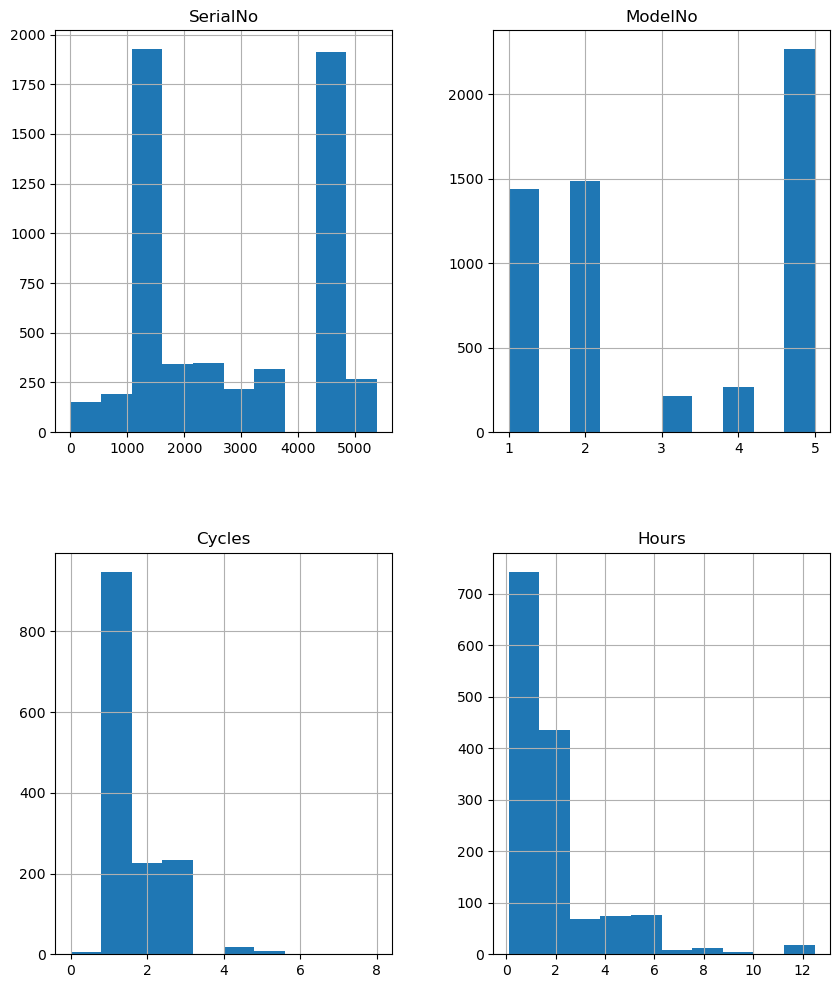

In [22]:
merged_df2.hist(figsize=(10,12))
plt.show()

In [38]:
# Calculate Asset Utilization Rate

merged_df2["Utilization Rate"] = merged_df2["Hours"] / merged_df2["Hours"].max()

In [26]:
print(merged_df2["Date"].head())  # See the first few dates
print(merged_df2.dtypes)  # Check if 'Date' is still datetime or turned into string/object


0    2012-11-02
1    2013-01-24
2    2013-01-24
3    2013-02-25
4    2013-03-06
Name: Date, dtype: object
Facility             object
SerialNo              int64
ModelNo             float64
Status Code          object
Date                 object
Cycles              float64
Hours               float64
ACTIVITY             object
START                object
END                  object
Utilization Rate    float64
dtype: object


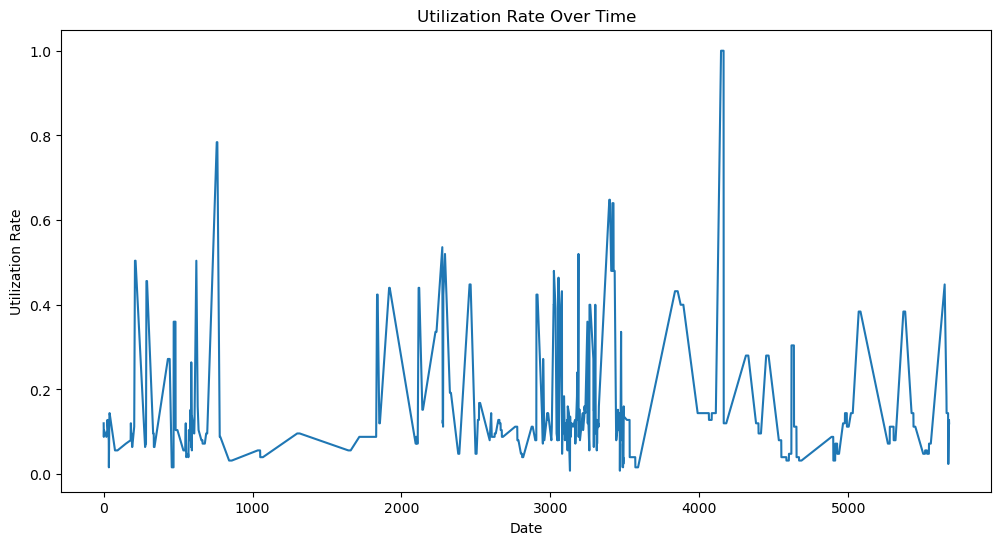

In [39]:
# Line plot of utilization rate over time
plt.figure(figsize=(12,6))
sns.lineplot(data=merged_df2, x=merged_df2.index, y="Utilization Rate")
plt.title("Utilization Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Utilization Rate")
plt.show()


In [41]:
 # Aggregate utilization by facility
facility_utilization = merged_df2.groupby("Facility")["Utilization Rate"].mean().reset_index()

In [85]:
print("Utilization Rate")

Utilization Rate


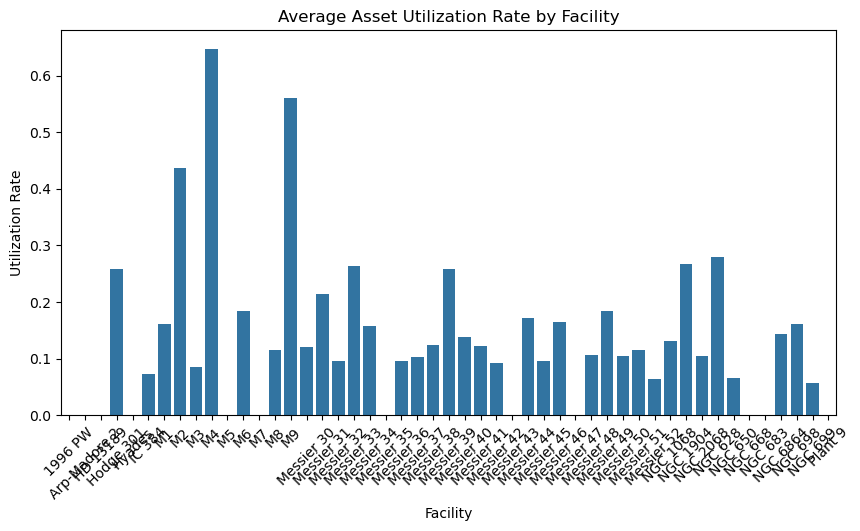

In [43]:
# Visualization: Utilization Rate by Facility
plt.figure(figsize=(10, 5))
sns.barplot(data=facility_utilization, x="Facility", y="Utilization Rate")
plt.xticks(rotation=45)
plt.title("Average Asset Utilization Rate by Facility")
plt.show()

In [44]:
print("Top 5 Facilities with Highest Utilization:")
print(facility_utilization.sort_values(by="Utilization Rate", ascending=False).head())

Top 5 Facilities with Highest Utilization:
    Facility  Utilization Rate
9         M4             0.648
14        M9             0.560
7         M2             0.436
41   NGC 628             0.280
39  NGC 1904             0.268


In [45]:
print("\nTop 5 Facilities with Lowest Utilization:")
print(facility_utilization.sort_values(by="Utilization Rate").head())


Top 5 Facilities with Lowest Utilization:
      Facility  Utilization Rate
47     NGC 699          0.056000
37  Messier 52          0.064000
42     NGC 650          0.065143
5       IC 384          0.072000
8           M3          0.084308


In [47]:
# Aggregate utilization by model
model_utilization = merged_df2.groupby("ModelNo")["Utilization Rate"].mean().reset_index()

In [77]:
print(model_utilization)

   ModelNo  Utilization Rate
0      1.0          0.099022
1      2.0          0.159398
2      3.0          0.156258
3      4.0          0.137582
4      5.0          0.167495


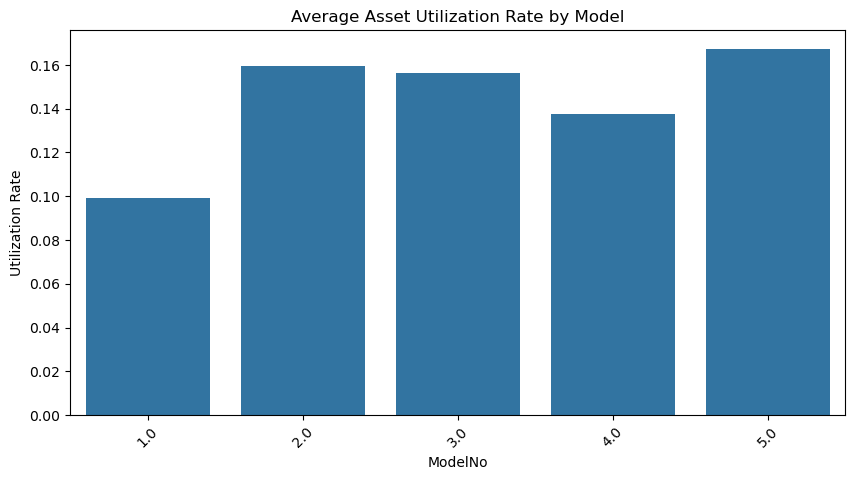

In [48]:
# Visualization: Utilization Rate by Model
plt.figure(figsize=(10, 5))
sns.barplot(data=model_utilization, x="ModelNo", y="Utilization Rate")
plt.xticks(rotation=45)
plt.title("Average Asset Utilization Rate by Model")
plt.show()

In [49]:
numeric_df = merged_df2.select_dtypes(include=[float, int])

In [50]:
corr = numeric_df.corr()

In [78]:
corr

,SerialNo,ModelNo,Cycles,Hours,Utilization Rate
SerialNo,1.000000,0.965612,0.211376,0.052654,0.052654
ModelNo,0.965612,1.000000,0.205248,0.112310,0.112310
Cycles,0.211376,0.205248,1.000000,0.218773,0.218773
Hours,0.052654,0.112310,0.218773,1.000000,1.000000
Utilization Rate,0.052654,0.112310,0.218773,1.000000,1.000000


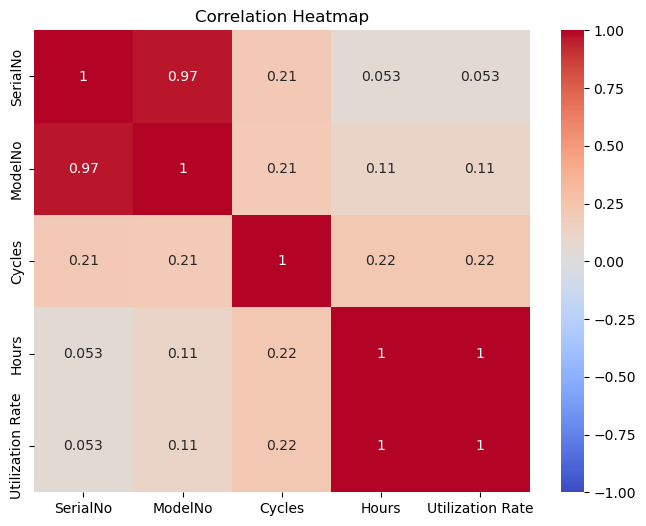

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
print(merged_df2.isnull().sum())

In [52]:
merged_df2["Utilization Rate"].fillna(merged_df2["Utilization Rate"].median(), inplace=True)
merged_df2["Hours"].fillna(merged_df2["Hours"].median(), inplace=True)

/var/folders/8y/7y64ckgn0rq30w9ylrrcq_hc0000gn/T/ipykernel_66195/1980273685.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df2["Utilization Rate"].fillna(merged_df2["Utilization Rate"].median(), inplace=True)
/var/folders/8y/7y64ckgn0rq30w9ylrrcq_hc0000gn/T/ipykernel_66195/1980273685.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

In [54]:
print("Unique Serial Numbers:", merged_df2["SerialNo"].nunique())
print("Unique Activities:", merged_df2["Status Code"].nunique())

Unique Serial Numbers: 48
Unique Activities: 12


In [66]:
# Convert Date to numerical format (days since the first recorded date)
merged_df["Date"] = pd.to_datetime(merged_df["Date"])
merged_df["Days_Since_Start"] = (merged_df["Date"] - merged_df["Date"].min()).dt.days


In [65]:
# Fixing NaN values

merged_df["END_MISSING"] = merged_df["End"].isna().astype(int)
# One-Hot Encode 'FACILITY' and 'ACTIVITY' columns
merged_encoded = pd.get_dummies(merged_df, columns=["Facility", "Activity"], drop_first=True)

merged_encoded["CYCLES_MISSING"] = merged_encoded["Cycles"].isna().astype(int)
merged_encoded["HOURS_MISSING"] = merged_encoded["Hours"].isna().astype(int)

KeyError: 'END'

**Time Series Analysis**

In [ ]:
merged_df2.head()

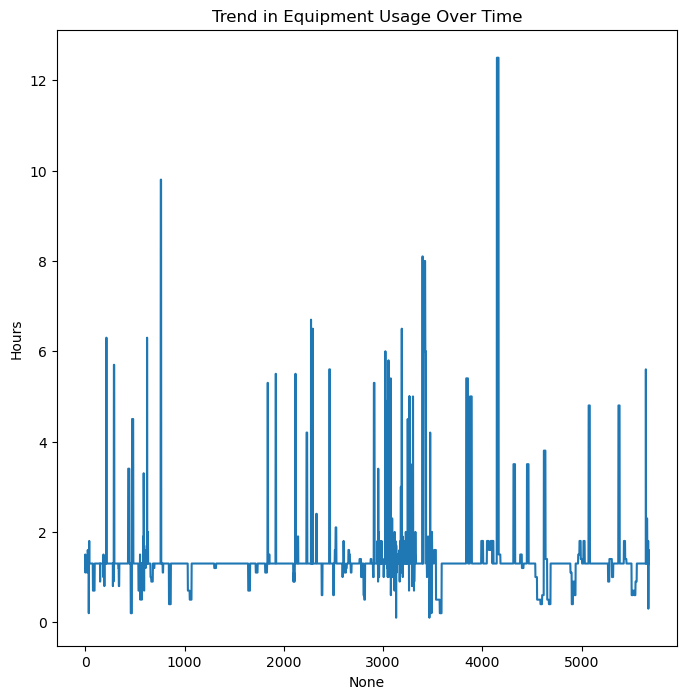

In [57]:
plt.figure(figsize=(8,8))
sns.lineplot(x=merged_df2.index, y=merged_df2["Hours"])
plt.title("Trend in Equipment Usage Over Time")
plt.show()

**Utilization Trends**

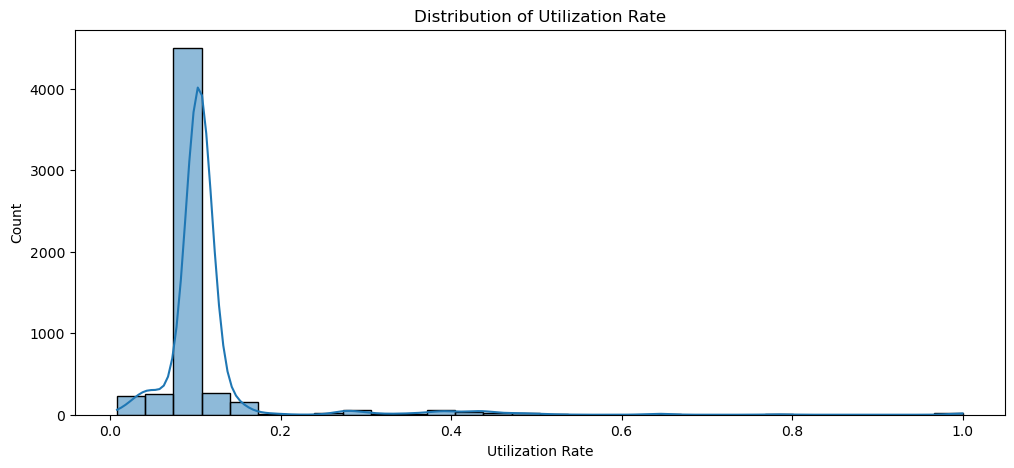

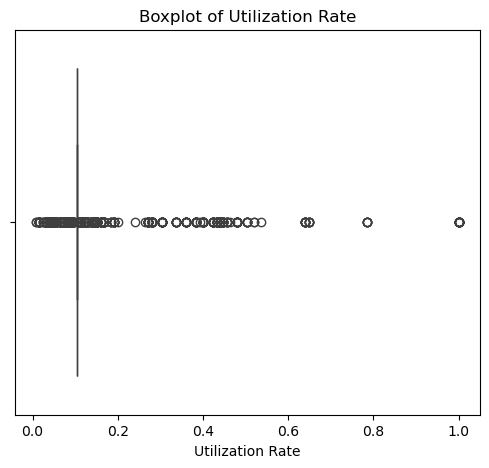

In [58]:
plt.figure(figsize=(12, 5))
sns.histplot(merged_df2["Utilization Rate"], bins=30, kde=True)
plt.title("Distribution of Utilization Rate")
plt.show()

plt.figure(figsize=(6, 5))
sns.boxplot(x=merged_df2["Utilization Rate"])
plt.title("Boxplot of Utilization Rate")
plt.show()


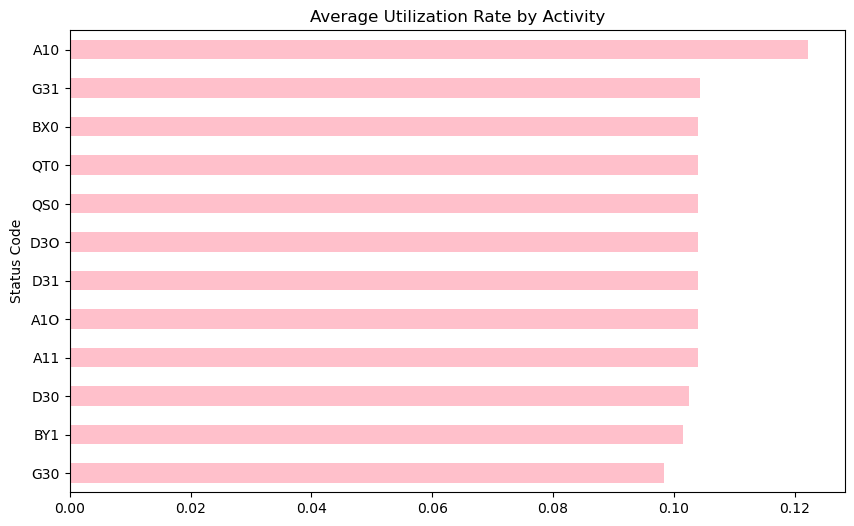

In [59]:
activity_utilization = merged_df2.groupby("Status Code")["Utilization Rate"].mean().sort_values()
activity_utilization.plot(kind="barh", figsize=(10, 6), color="pink")
plt.title("Average Utilization Rate by Activity")
plt.show()


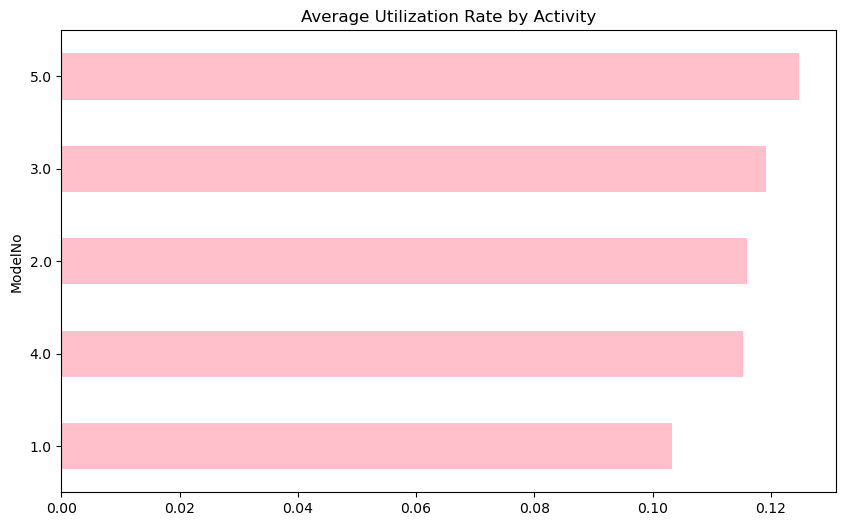

In [60]:
activity_utilization = merged_df2.groupby("ModelNo")["Utilization Rate"].mean().sort_values()
activity_utilization.plot(kind="barh", figsize=(10, 6), color="pink")
plt.title("Average Utilization Rate by Activity")
plt.show()

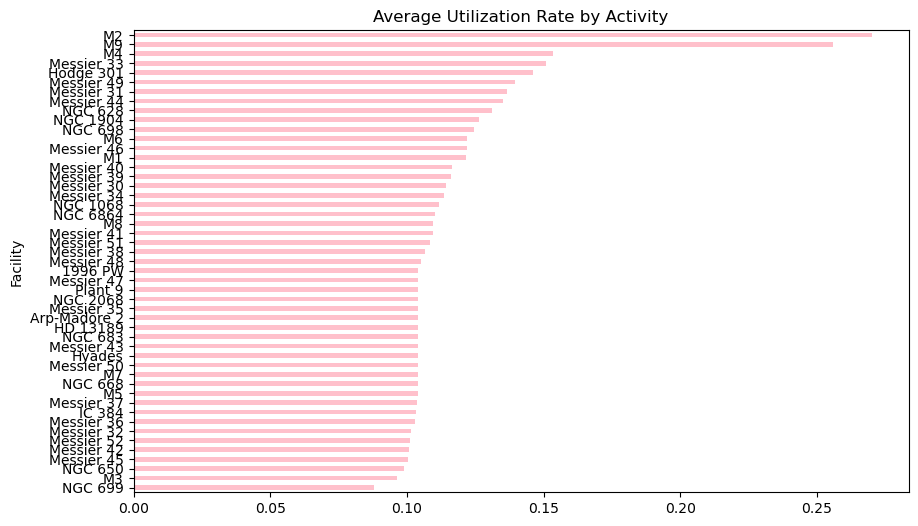

In [61]:
activity_utilization = merged_df2.groupby("Facility")["Utilization Rate"].mean().sort_values()
activity_utilization.plot(kind="barh", figsize=(10, 6), color="pink")
plt.title("Average Utilization Rate by Activity")
plt.show()

In [62]:
serial_utilization = merged_df2.groupby("SerialNo")["Utilization Rate"].mean().sort_values(ascending=False)
print(serial_utilization.head(10))  # Top 10 serials

SerialNo
3446    0.222400
4757    0.214834
1712    0.152640
4974    0.147000
3115    0.145600
4771    0.143619
3343    0.139143
3282    0.135143
745     0.133529
3335    0.128727
Name: Utilization Rate, dtype: float64


In [75]:


# Resample to monthly data
merged_df_monthly = merged_df2["Utilization Rate"].resample("M").mean()

# Rolling average
df_monthly_rolling = merged_df_monthly.rolling(window=3).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df_monthly, label="Monthly Utilization Rate", marker="o")
plt.plot(df_monthly_rolling, label="3-Month Rolling Avg", linestyle="dashed")
plt.legend()
plt.title("Monthly Utilization Rate with Rolling Average")
plt.show()


/var/folders/8y/7y64ckgn0rq30w9ylrrcq_hc0000gn/T/ipykernel_66195/393026582.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  merged_df_monthly = merged_df2["Utilization Rate"].resample("M").mean()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [73]:
merged_df2.columns

Index(['Facility', 'SerialNo', 'ModelNo', 'Status Code', 'Date', 'Cycles',
       'Hours', 'ACTIVITY', 'START', 'END', 'Utilization Rate'],
      dtype='object')

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(merged_df_monthly.dropna(), model="additive", period=12)

plt.figure(figsize=(10, 8))
decomposed.plot()
plt.show()

NameError: name 'merged_df_monthly' is not defined

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(merged_df2["Utilization Rate"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

plot_acf(merged_df2["Utilization Rate"].dropna(), ax=ax[0])  # Autocorrelation plot
plot_pacf(merged_df2["Utilization Rate"].dropna(), ax=ax[1])  # Partial Autocorrelation plot

plt.show()


In [ ]:
# ARIMA model (adjust p,d,q based on ACF/PACF results)
model = ARIMA(merged_df2["Utilization Rate"].dropna(), order=(1,1,1))
results = model.fit()

# Summary of the model
print(results.summary())

# Forecasting
forecast = results.forecast(steps=10)  # Predict next 10 time points
plt.plot(merged_df2.index, merged_df2["Utilization Rate"], label="Actual")
plt.plot(pd.date_range(merged_df2.index[-1], periods=10, freq="D"), forecast, label="Forecast", linestyle="dashed")
plt.legend()
plt.show()


In [87]:
status_df = pd.read_csv('/Users/brashonford/StatusCodes.csv', parse_dates=['Date'])
cycles_df = pd.read_csv('/Users/brashonford/Cycles.csv', parse_dates=['Date'])
schedule_df = pd.read_csv('/Users/brashonford/Schedule.csv', parse_dates=['START', 'END'])


In [88]:
# Inspect the data
print("Status Codes Data:")
print(status_df.head())
print("\nCycles Data:")
print(cycles_df.head())
print("\nSchedule Data:")
print(schedule_df.head())

Status Codes Data:
     Facility  SerialNo  ModelNo Status Code       Date
0  Messier 37         1      1.0         A10 2012-11-02
1  Messier 37         1      1.0         A10 2013-01-24
2  Messier 37         1      1.0         G31 2013-02-25
3  Messier 37         1      1.0         A10 2013-03-06
4  Messier 37         1      1.0         A10 2013-04-03

Cycles Data:
   SerialNo  Cycles  Hours       Date
0         1     1.0    1.7 2013-01-07
1         1     1.0    1.4 2013-01-07
2         1     1.0    1.4 2013-01-07
3         1     1.0    1.3 2013-01-08
4         1     1.0    1.4 2013-01-08

Schedule Data:
       FACILITY     ACTIVITY      START        END
0        HYADES  ACTIVITY U2 2004-01-01        NaT
1       PLANT 9  ACTIVITY U1 2004-01-01        NaT
2  ARP-MADORE 2  ACTIVITY U3 2004-01-01        NaT
3       1996 PW  ACTIVITY Q3 2004-01-01        NaT
4            M1   ACTIVITY B 2012-10-30 2013-02-03


In [95]:
# Inspect the data
print("Status Codes Data:")
print(status_df.head())
print("\nCycles Data:")
print(cycles_df.head())
print("\nSchedule Data:")
print(schedule_df.head())

Status Codes Data:
     facility  serialno  modelno status code       date
0  Messier 37         1      1.0         A10 2012-11-02
1  Messier 37         1      1.0         A10 2013-01-24
2  Messier 37         1      1.0         G31 2013-02-25
3  Messier 37         1      1.0         A10 2013-03-06
4  Messier 37         1      1.0         A10 2013-04-03

Cycles Data:
   serialno  cycles  hours       date
0         1     1.0    1.7 2013-01-07
1         1     1.0    1.4 2013-01-07
2         1     1.0    1.4 2013-01-07
3         1     1.0    1.3 2013-01-08
4         1     1.0    1.4 2013-01-08

Schedule Data:
       facility     activity      start        end  key
0        HYADES  ACTIVITY U2 2004-01-01        NaT    1
1       PLANT 9  ACTIVITY U1 2004-01-01        NaT    1
2  ARP-MADORE 2  ACTIVITY U3 2004-01-01        NaT    1
3       1996 PW  ACTIVITY Q3 2004-01-01        NaT    1
4            M1   ACTIVITY B 2012-10-30 2013-02-03    1


In [94]:
status_df.columns = status_df.columns.str.lower()
cycles_df.columns = cycles_df.columns.str.lower()
schedule_df.columns = schedule_df.columns.str.lower()

In [97]:
# Merge Status and Cycles data on serialno and date
merged_df = pd.merge(status_df, cycles_df, on=['serialno', 'date'], how='left')

In [92]:
merged_df.columns

Index(['Facility', 'SerialNo', 'ModelNo', 'Status Code', 'Date', 'Cycles',
       'Hours'],
      dtype='object')

In [98]:
# Merge with Schedule data based on facility and date range
schedule_df['key'] = 1  # Temporary key for cross join
merged_df['key'] = 1
merged2_df = merged_df.merge(schedule_df, on=['facility', 'key'], how='left').drop(columns=['key'])

In [100]:
merged2_df.head()

,facility,serialno,modelno,status code,date,cycles,hours,activity,start,end
0,Messier 37,1,1.0,A10,2012-11-02,NaN,NaN,NaN,NaT,NaT
1,Messier 37,1,1.0,A10,2013-01-24,1.0,1.5,NaN,NaT,NaT
2,Messier 37,1,1.0,A10,2013-01-24,1.0,1.1,NaN,NaT,NaT
3,Messier 37,1,1.0,G31,2013-02-25,1.0,1.3,NaN,NaT,NaT
4,Messier 37,1,1.0,A10,2013-03-06,NaN,NaN,NaN,NaT,NaT


In [101]:
# Summary of key metrics
print("\nSummary Statistics:")
print(f"Total Unique Assets: {merged2_df['serialno'].nunique()}")
print(f"Total Unique Facilities: {merged2_df['facility'].nunique()}")
print(f"Total Unique Activities: {merged2_df['activity'].nunique()}")


Summary Statistics:
Total Unique Assets: 48
Total Unique Facilities: 49
Total Unique Activities: 24


In [102]:
# Utilization per facility
facility_utilization = merged2_df.groupby('facility')[['cycles', 'hours']].sum().reset_index()
print("\nTotal Cycles and Hours per Facility:")
print(facility_utilization)


Total Cycles and Hours per Facility:
        facility  cycles  hours
0        1996 PW     0.0    0.0
1   Arp-Madore 2     0.0    0.0
2       HD 13189     0.0    0.0
3      Hodge 301     8.0    9.7
4         Hyades     0.0    0.0
5         IC 384     1.0    0.9
6             M1   342.0  383.8
7             M2    32.0  174.4
8             M3   325.0  178.1
9             M4     5.0   40.5
10            M5     0.0    0.0
11            M6   117.0  209.3
12            M7     0.0    0.0
13            M8   408.0  319.6
14            M9    72.0  252.0
15    Messier 30     8.0   12.1
16    Messier 31    28.0   53.4
17    Messier 32    69.0   38.5
18    Messier 33    10.0   16.5
19    Messier 34     6.0    9.8
20    Messier 35     0.0    0.0
21    Messier 36     2.0    2.4
22    Messier 37    15.0   18.0
23    Messier 38     7.0    7.8
24    Messier 39     6.0    9.7
25    Messier 40    20.0   33.0
26    Messier 41    14.0   21.5
27    Messier 42    18.0   15.0
28    Messier 43     0.0    0.0
29

In [103]:
# Utilization per model
model_utilization = merged2_df.groupby('modelno')[['cycles', 'hours']].sum().reset_index()
print("\nTotal Cycles and Hours per Model:")
print(model_utilization)


Total Cycles and Hours per Model:
   modelno  cycles   hours
0      1.0   308.0   278.5
1      2.0   423.0   635.6
2      3.0    84.0   121.1
3      4.0   113.0   156.5
4      5.0  1301.0  1557.7


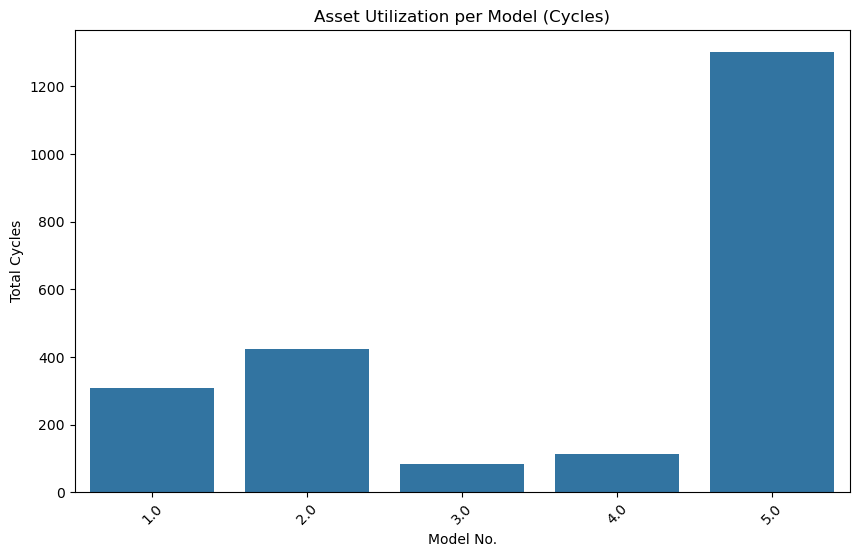

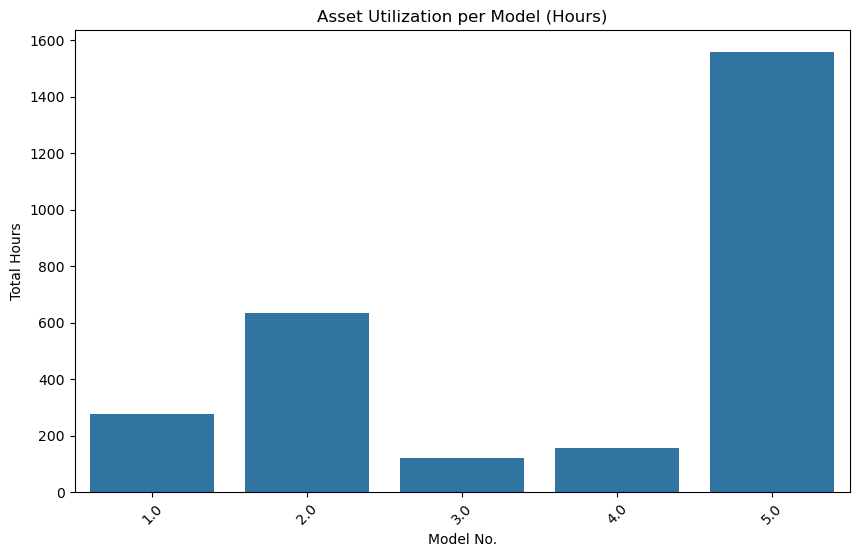

In [109]:
# Plot Cycles and Hours per Model (for Slide 5)
plt.figure(figsize=(10, 6))
sns.barplot(x='modelno', y='cycles', data=model_utilization)
plt.xlabel('Model No.')
plt.ylabel('Total Cycles')
plt.title('Asset Utilization per Model (Cycles)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='modelno', y='hours', data=model_utilization)
plt.xlabel('Model No.')
plt.ylabel('Total Hours')
plt.title('Asset Utilization per Model (Hours)')
plt.xticks(rotation=45)
plt.show()

In [104]:
# Average usage per asset
asset_avg_usage = merged2_df.groupby('serialno')[['cycles', 'hours']].sum().reset_index()
asset_avg_usage['avg_cycles_per_day'] = asset_avg_usage['cycles'] / merged2_df['date'].nunique()
asset_avg_usage['avg_hours_per_day'] = asset_avg_usage['hours'] / merged2_df['date'].nunique()
print("\nAverage Usage per Asset:")
print(asset_avg_usage.head())


Average Usage per Asset:
   serialno  cycles  hours  avg_cycles_per_day  avg_hours_per_day
0         1     7.0    7.9            0.009421           0.010633
1       263    24.0   20.3            0.032301           0.027322
2       496     1.0    0.9            0.001346           0.001211
3       706     0.0    0.0            0.000000           0.000000
4       734     8.0    9.1            0.010767           0.012248


In [105]:
# Identifying overutilized and underutilized assets
model_avg_usage = merged2_df.groupby('modelno')[['cycles', 'hours']].mean().reset_index()
overutilized_assets = asset_avg_usage[asset_avg_usage['cycles'] > 1.5 * model_avg_usage['cycles'].mean()]
underutilized_assets = asset_avg_usage[asset_avg_usage['cycles'] < 0.5 * model_avg_usage['cycles'].mean()]

print("\nOverutilized Assets:")
print(overutilized_assets)
print("\nUnderutilized Assets:")
print(underutilized_assets)


Overutilized Assets:
    serialno  cycles  hours  avg_cycles_per_day  avg_hours_per_day
0          1     7.0    7.9            0.009421           0.010633
1        263    24.0   20.3            0.032301           0.027322
4        734     8.0    9.1            0.010767           0.012248
5        745    29.0   32.9            0.039031           0.044280
6        758    43.0   41.1            0.057873           0.055316
7       1155   117.0  131.3            0.157470           0.176716
8       1163    51.0   29.0            0.068641           0.039031
9       1169     3.0    9.6            0.004038           0.012921
10      1188    50.0   86.5            0.067295           0.116420
11      1244   133.0  108.3            0.179004           0.145760
12      1375    10.0   34.0            0.013459           0.045760
13      1387    35.0   42.0            0.047106           0.056528
14      1456    23.0   70.6            0.030956           0.095020
15      1712    12.0   23.0            0

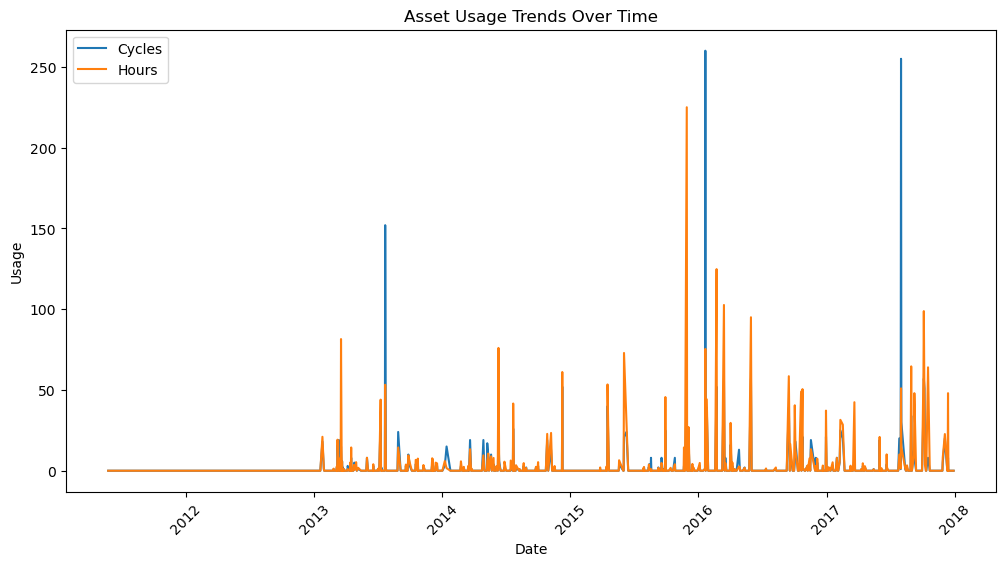

In [106]:
# Time-Based Analysis - Asset usage trends
time_trends = merged2_df.groupby('date')[['cycles', 'hours']].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=time_trends, x='date', y='cycles', label='Cycles')
sns.lineplot(data=time_trends, x='date', y='hours', label='Hours')
plt.xlabel('Date')
plt.ylabel('Usage')
plt.title('Asset Usage Trends Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [122]:
time_trends

,date,cycles,hours
0,2011-05-24,0.0,0.0
1,2011-05-26,0.0,0.0
2,2011-11-08,0.0,0.0
3,2011-11-29,0.0,0.0
4,2012-02-10,0.0,0.0
...,...,...,...
738,2017-12-13,8.0,48.0
739,2017-12-14,0.0,0.0
740,2017-12-15,0.0,0.0
741,2017-12-28,0.0,0.0


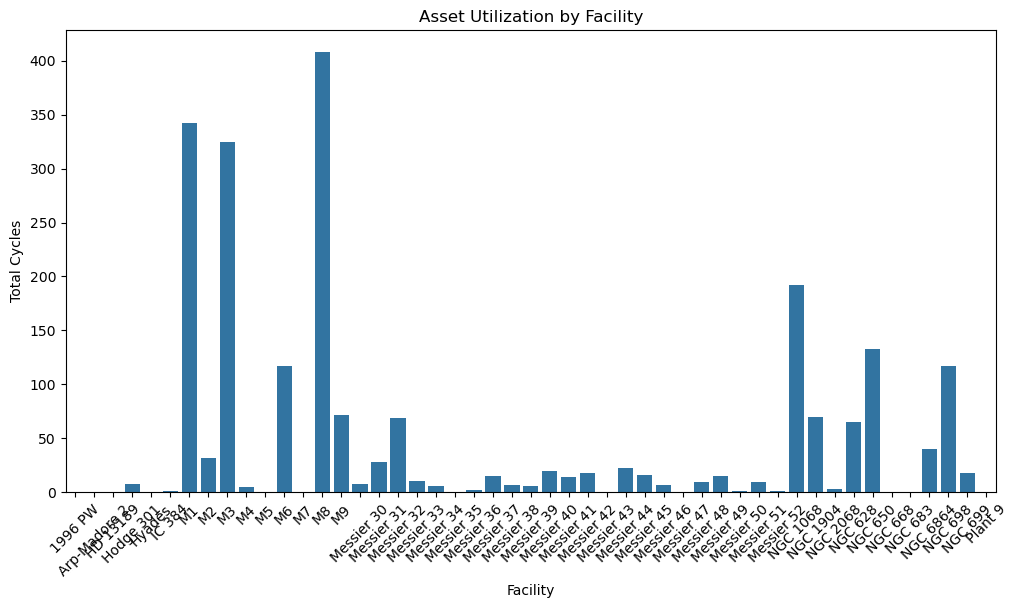

In [107]:
# Facility-Level Insights - Asset utilization per facility
plt.figure(figsize=(12, 6))
sns.barplot(data=facility_utilization, x='facility', y='cycles')
plt.xlabel('Facility')
plt.ylabel('Total Cycles')
plt.title('Asset Utilization by Facility')
plt.xticks(rotation=45)
plt.show()

In [108]:
# Lifecycle Analysis - Time spent in each status
time_in_status = merged2_df.groupby(['status code'])['date'].count().reset_index()
time_in_status.columns = ['status code', 'days_in_status']
print("\nTime Spent in Each Status:")
print(time_in_status)


Time Spent in Each Status:
   status code  days_in_status
0          A10            3914
1          A11             209
2          A1O               2
3          BX0               6
4          BY1              16
5          D30             142
6          D31             277
7          D3O               2
8          G30             199
9          G31             908
10         QS0               1
11         QT0               1


/var/folders/8y/7y64ckgn0rq30w9ylrrcq_hc0000gn/T/ipykernel_66195/2322477649.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='status code', y='days_in_status', data=time_in_status, palette='viridis')


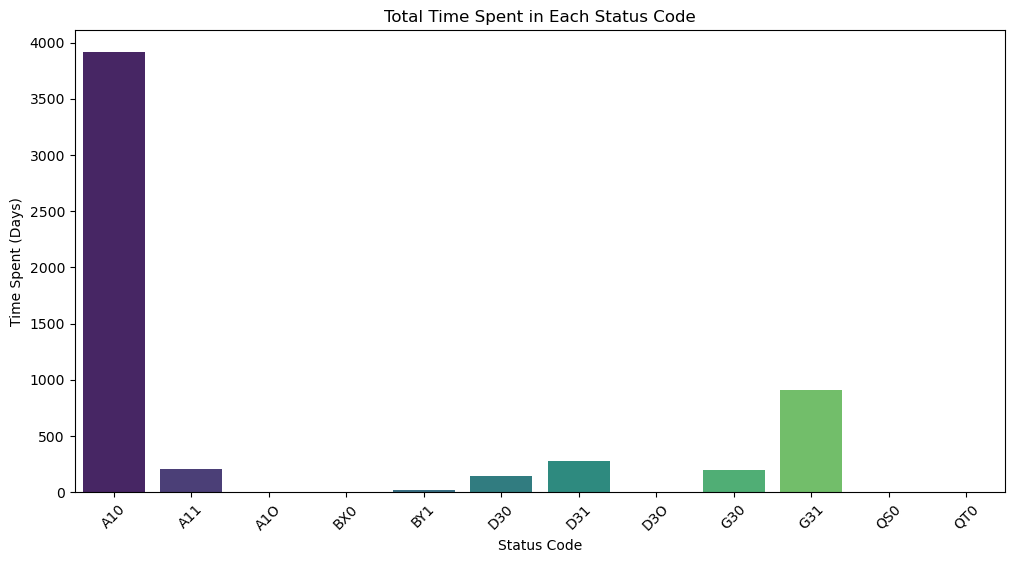

In [119]:
# Plotting the total time spent in each status
plt.figure(figsize=(12, 6))
sns.barplot(x='status code', y='days_in_status', data=time_in_status, palette='viridis')
plt.title('Total Time Spent in Each Status Code')
plt.xlabel('Status Code')
plt.ylabel('Time Spent (Days)')
plt.xticks(rotation=45)
plt.show()


Overutilized Assets:
    serialno  cycles  hours  avg_cycles_per_day  avg_hours_per_day
0          1     7.0    7.9            0.009421           0.010633
1        263    24.0   20.3            0.032301           0.027322
4        734     8.0    9.1            0.010767           0.012248
5        745    29.0   32.9            0.039031           0.044280
6        758    43.0   41.1            0.057873           0.055316
7       1155   117.0  131.3            0.157470           0.176716
8       1163    51.0   29.0            0.068641           0.039031
9       1169     3.0    9.6            0.004038           0.012921
10      1188    50.0   86.5            0.067295           0.116420
11      1244   133.0  108.3            0.179004           0.145760
12      1375    10.0   34.0            0.013459           0.045760
13      1387    35.0   42.0            0.047106           0.056528
14      1456    23.0   70.6            0.030956           0.095020
15      1712    12.0   23.0            0

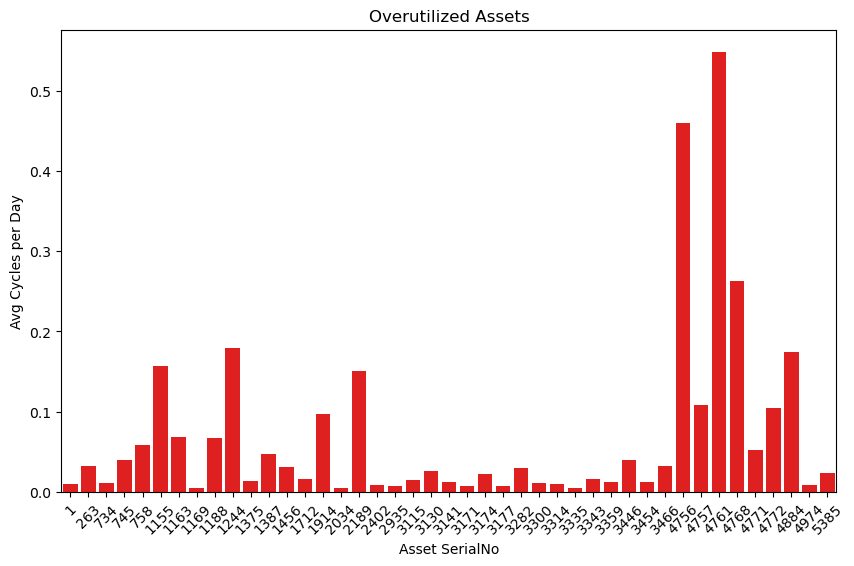

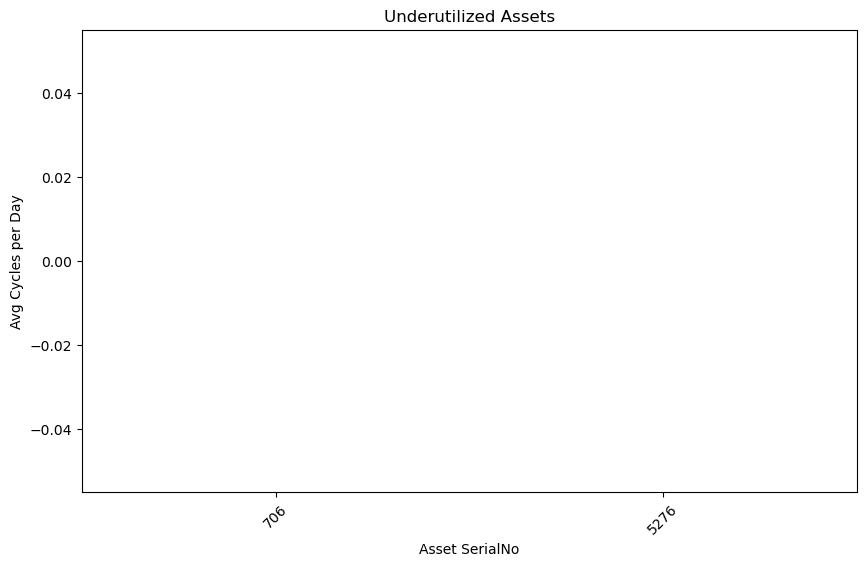

In [114]:
model_avg_usage = merged2_df.groupby('modelno')[['cycles', 'hours']].mean().reset_index()
overutilized_assets = asset_avg_usage[asset_avg_usage['cycles'] > 1.5 * model_avg_usage['cycles'].mean()]
underutilized_assets = asset_avg_usage[asset_avg_usage['cycles'] < 0.5 * model_avg_usage['cycles'].mean()]

print("\nOverutilized Assets:")
print(overutilized_assets)
print("\nUnderutilized Assets:")
print(underutilized_assets)



# Plot overutilized and underutilized assets (for Slide 5)
plt.figure(figsize=(10, 6))
sns.barplot(x='serialno', y='avg_cycles_per_day', data=overutilized_assets, color='red')
plt.xlabel('Asset SerialNo')
plt.ylabel('Avg Cycles per Day')
plt.title('Overutilized Assets')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='serialno', y='avg_cycles_per_day', data=underutilized_assets, color='blue')
plt.xlabel('Asset SerialNo')
plt.ylabel('Avg Cycles per Day')
plt.title('Underutilized Assets')
plt.xticks(rotation=45)
plt.show()

In [116]:
overutilized_assets.head(3)

,serialno,cycles,hours,avg_cycles_per_day,avg_hours_per_day
0,1,7.0,7.9,0.009421,0.010633
1,263,24.0,20.3,0.032301,0.027322
4,734,8.0,9.1,0.010767,0.012248


In [125]:
model_avg_usage

,modelno,cycles,hours
0,1.0,1.368889,1.237778
1,2.0,1.326019,1.992476
2,3.0,1.354839,1.953226
3,4.0,1.241758,1.719780
4,5.0,1.748656,2.093683


In [126]:
facility_utilization

,facility,cycles,hours
0,1996 PW,0.0,0.0
1,Arp-Madore 2,0.0,0.0
2,HD 13189,0.0,0.0
3,Hodge 301,8.0,9.7
4,Hyades,0.0,0.0
5,IC 384,1.0,0.9
6,M1,342.0,383.8
7,M2,32.0,174.4
8,M3,325.0,178.1
9,M4,5.0,40.5
